In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Jan 24 19:57:27 2020

@author: aymanjabri
Classify one of the MNIST datasets with adaptive learning rate, run multiple 
batch sizes and learning rates and other hyper parameters
"""
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision as tv
from torchvision import transforms,datasets,models
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from collections import Counter,OrderedDict,namedtuple
from itertools import product

In [2]:
#GPU
if torch.cuda.is_available():
    device=torch.device('cuda:0')
else:
    device=torch.device('cpu')

In [3]:
#Transforms
tfms = transforms.Compose([transforms.ToTensor(),
                           transforms.Normalize((0.5,),(0.5,))])
#Download data into datasets
trns = datasets.MNIST('/Users/aymanjabri/notebooks/MNIST',train=True,transform=
                    tfms,download=True)
tsts = datasets.MNIST('/Users/aymanjabri/notebooks/MNIST',train=False,transform=
                    tfms,download=True)
#check for datasets imbalance:
# print(sorted(Counter(trns.targets.numpy()).items()))
# print(sorted(Counter(tsts.targets.numpy()).items()))

#Combine test and training datasets
ds = torch.utils.data.ConcatDataset((trns,tsts))

#Split training and validation sets
trainset,validset = torch.utils.data.random_split(ds,[50000,20000])

train = torch.utils.data.DataLoader(trainset,batch_size=100,shuffle=True)
valid = torch.utils.data.DataLoader(validset,batch_size=500)

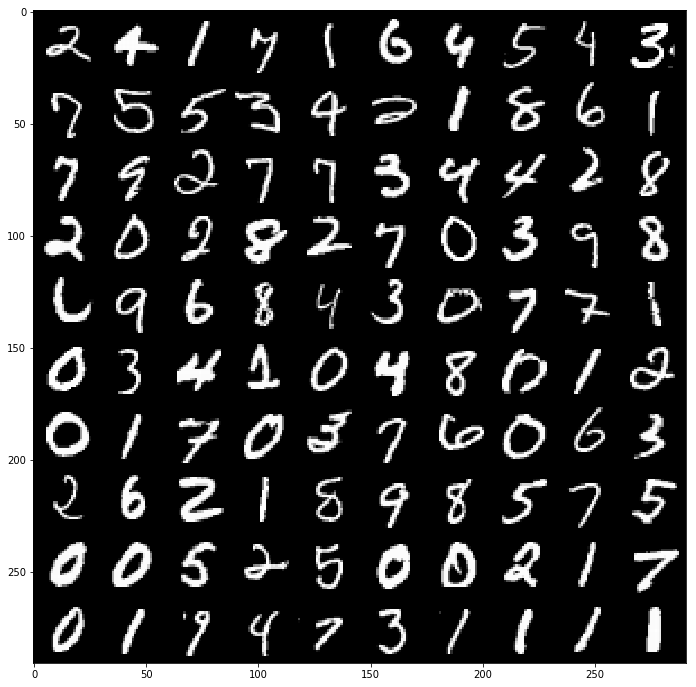

In [4]:
#view the data
img,label = next(iter(train))
imgs = tv.utils.make_grid(img,nrow=10,padding=1,normalize=True)
plt.figure(figsize=(12,12))
plt.imshow(imgs.permute(1,2,0))


In [5]:

#Import CNN from scratch
class Net(nn.Module):
    def __init__(self,out,kernel):
        super().__init__()
#         self.convs = nn.Sequential(OrderedDict([
#             ('conv1',nn.Conv2d(1,out,kernel,padding=1,bias=False)),
#             ('relu1',nn.ReLU(inplace=True)),
#             ('bn1',nn.BatchNorm2d(out)),
#             ('conv2',nn.Conv2d(out,out*2,kernel,padding=1,bias=False)),
#             ('relu2',nn.ReLU(inplace=True)),
#             ('bn2',nn.BatchNorm2d(out*2)),
#             ('pool1',nn.AdaptiveMaxPool2d(out*2)),
#             ('conv3',nn.Conv2d(out*2,out*4,kernel,padding=1,bias=False)),
#             ('relu3',nn.ReLU(inplace=True)),
#             ('bn3',nn.BatchNorm2d(out*4)),
#             ('pool2',nn.AdaptiveMaxPool2d(1)),
#             ('flat',nn.Flatten()),
#             ]))
        self.conv1 = nn.Conv2d(1,out,kernel,padding=1)
        self.bn1 = nn.BatchNorm2d(out)
        self.conv2 = nn.Conv2d(out,out,kernel,padding=1)
        self.bn2 = nn.BatchNorm2d(out)
        self.pool1 = nn.AdaptiveMaxPool2d(1)
        self.pool2 = nn.AdaptiveAvgPool2d(1)
        self.lin1 = nn.Linear(out*2,out)
        self.bn = nn.BatchNorm1d(out)
        self.lin2 = nn.Linear(out,10)
    def forward(self,x):
        x = self.bn1(F.relu_(self.conv1(x)))
        x = self.bn2(F.relu_(self.conv2(x)))
        p1 = self.pool1(x)
        p2 = self.pool2(x)
        x = torch.cat((p1,p2),dim=1)
        x = x.view(x.size(0),-1)
#         x = self.convs(x)
        x = self.bn(F.relu(self.lin1(x)))
        x = self.lin2(x)
        return x

In [6]:
def get_correct_num(predict,label):
    correct = torch.argmax(predict.softmax(dim=1),dim=1).eq(label)
    return correct.sum().item()

def learn(net,data,epochs,lr=1e-3):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(),lr=lr)
    total_losses = []
    total_accuracy = []
    for epoch in range(1,epochs+1):
        e_loss = 0
        correct = 0
        for batch in data:
            optimizer.zero_grad()
            img,label = batch
            if torch.cuda.is_available(): img,label=img.to(device),label.to(device)
            output = net(img)
            loss = criterion(output,label)
            loss.backward()
            optimizer.step()
            e_loss += loss.item()
            correct += get_correct_num(output,label)
        e_acc = round(correct/(len(data)*data.batch_size)*100,5)
        print('''Epoch:{} Training Loss {} Training Accuracy {}%
              '''.format(epoch,e_loss,e_acc))
        total_losses.append(e_loss)
        total_accuracy.append(e_acc)
    return total_losses,total_accuracy

In [7]:
class runner():
    def __init__(self,out_channels,kernel_size,data,epochs,lr=1e-3):
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.data = data
        self.epochs = epochs
        self.lr = lr
    def run(self):
        net = Net(self.out_channels,self.kernel_size).to(device)
        l,a = learn(net,self.data,self.epochs,self.lr)
        
        fig, ax1 = plt.subplots()
        color = 'tab:red'
        ax1.set_xlabel('lr={} out_channels={} kernel={}'.format(
            self.lr,self.out_channels,self.kernel_size))
        ax1.set_ylabel('losses', color=color)
        ax1.plot(l, color=color)
        ax1.tick_params(axis='y', labelcolor=color)
        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
        color = 'tab:blue'
        ax2.set_ylabel('accuracy', color=color)  # we already handled the x-label with ax1
        ax2.plot(a, color=color)
        ax2.tick_params(axis='y', labelcolor=color)
        fig.tight_layout()

In [8]:
'''Lets create a small dataloader to overfit the model with
before introducing the full dataset'''
#Define sampling method

weights= 100/(torch.bincount(trns.targets).double())
weighted = torch.utils.data.WeightedRandomSampler(weights,num_samples=100
                                               ,replacement=True)
random = torch.utils.data.RandomSampler(trns,replacement=True,num_samples=100)

#After trying many different sampling methods i went with random because it gave the most balanced results
dl_small= torch.utils.data.DataLoader(trns,batch_size=100,sampler=random)

xs,ys = next(iter(dl_small))
# print(sorted(Counter(ys.numpy()).items()))

Epoch:1 Training Loss 2.5180017948150635 Training Accuracy 3.0%
              
Epoch:2 Training Loss 1.5104643106460571 Training Accuracy 62.0%
              
Epoch:3 Training Loss 1.3617234230041504 Training Accuracy 64.0%
              
Epoch:4 Training Loss 0.9792355895042419 Training Accuracy 80.0%
              
Epoch:5 Training Loss 0.8142783641815186 Training Accuracy 83.0%
              
Epoch:6 Training Loss 0.8154760599136353 Training Accuracy 86.0%
              
Epoch:7 Training Loss 0.7097852230072021 Training Accuracy 91.0%
              
Epoch:8 Training Loss 0.7119200229644775 Training Accuracy 85.0%
              
Epoch:9 Training Loss 0.616892397403717 Training Accuracy 90.0%
              
Epoch:10 Training Loss 0.5151877403259277 Training Accuracy 94.0%
              
Epoch:11 Training Loss 0.5612154006958008 Training Accuracy 88.0%
              
Epoch:12 Training Loss 0.5163598656654358 Training Accuracy 93.0%
              
Epoch:13 Training Loss 0.44684356451034

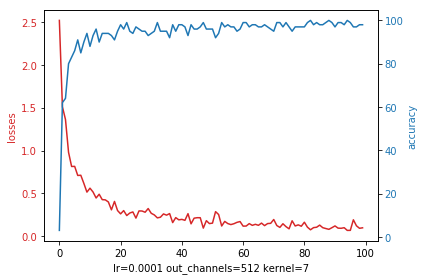

In [14]:
r = runner(512,7,dl_small,100,lr=1e-4)
r.run()

Epoch:1 Training Loss 55.57446805853397 Training Accuracy 97.742%
              
Epoch:2 Training Loss 15.421825754456222 Training Accuracy 99.338%
              
Epoch:3 Training Loss 8.42909611784853 Training Accuracy 99.678%
              
Epoch:4 Training Loss 5.116558752954006 Training Accuracy 99.846%
              
Epoch:5 Training Loss 2.962576759280637 Training Accuracy 99.934%
              


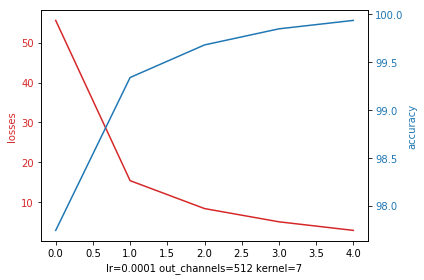

In [9]:
t = runner(512,7,train,5,lr=1e-4);t.run()

In [28]:
def predict_all(net,loader):
    with torch.no_grad():
        predict = torch.tensor([]).to(device)
        labels = torch.tensor([]).int().to(device)
        for img,label in loader:
            if torch.cuda.is_available(): img,label=img.to(device),label.to(device)
            p=net(img)
            predict = torch.cat((predict,p),dim=0)
            labels = torch.cat((labels,label.int()),dim=0)
        return predict,labels

In [14]:
net = Net(512,7).to(device)

In [40]:
p,l = predict_all(net,valid)

In [41]:
get_correct_num(p,l)/len(p)

0.99055

In [34]:
learn(net,dl_small,100)

Epoch:1 Training Loss 2.376269817352295 Training Accuracy 10.0%
              
Epoch:2 Training Loss 2.035762071609497 Training Accuracy 33.0%
              
Epoch:3 Training Loss 1.5022510290145874 Training Accuracy 61.0%
              
Epoch:4 Training Loss 1.1431347131729126 Training Accuracy 70.0%
              
Epoch:5 Training Loss 1.0184177160263062 Training Accuracy 77.0%
              
Epoch:6 Training Loss 0.858437180519104 Training Accuracy 86.0%
              
Epoch:7 Training Loss 0.8063319325447083 Training Accuracy 87.0%
              
Epoch:8 Training Loss 0.6011732816696167 Training Accuracy 95.0%
              
Epoch:9 Training Loss 0.5694274306297302 Training Accuracy 93.0%
              
Epoch:10 Training Loss 0.5534253120422363 Training Accuracy 89.0%
              
Epoch:11 Training Loss 0.32884329557418823 Training Accuracy 97.0%
              
Epoch:12 Training Loss 0.39760467410087585 Training Accuracy 93.0%
              
Epoch:13 Training Loss 0.4545366168022

([2.376269817352295,
  2.035762071609497,
  1.5022510290145874,
  1.1431347131729126,
  1.0184177160263062,
  0.858437180519104,
  0.8063319325447083,
  0.6011732816696167,
  0.5694274306297302,
  0.5534253120422363,
  0.32884329557418823,
  0.39760467410087585,
  0.4545366168022156,
  0.39047184586524963,
  0.3716292977333069,
  0.27515774965286255,
  0.33649080991744995,
  0.3747367560863495,
  0.3639439046382904,
  0.2190825492143631,
  0.35926440358161926,
  0.3222748637199402,
  0.4279975891113281,
  0.197018101811409,
  0.2303258180618286,
  0.21934132277965546,
  0.2102680653333664,
  0.20450858771800995,
  0.2234894335269928,
  0.1675880253314972,
  0.2216310054063797,
  0.19719280302524567,
  0.1881379634141922,
  0.231675922870636,
  0.1448192447423935,
  0.15619637072086334,
  0.14335091412067413,
  0.10104213654994965,
  0.16935738921165466,
  0.1630556881427765,
  0.11448448151350021,
  0.10647234320640564,
  0.14304566383361816,
  0.1298426240682602,
  0.1639268845319748,

In [39]:
learn(net,train,5)

Epoch:1 Training Loss 31.207750715781003 Training Accuracy 98.184%
              
Epoch:2 Training Loss 13.241688948124647 Training Accuracy 99.254%
              
Epoch:3 Training Loss 7.880020847835112 Training Accuracy 99.546%
              
Epoch:4 Training Loss 4.687020835524891 Training Accuracy 99.756%
              
Epoch:5 Training Loss 4.307269608078059 Training Accuracy 99.75%
              


([31.207750715781003,
  13.241688948124647,
  7.880020847835112,
  4.687020835524891,
  4.307269608078059],
 [98.184, 99.254, 99.546, 99.756, 99.75])